In [1]:
import brian2
from brian2tools import *
from brian2 import *
from struct import unpack
from PIL import Image
import numpy as np
import matplotlib.cm as cmap
import matplotlib.pyplot as plt
import os.path
import pickle as pickle
import scipy
import scipy.signal as signal
import time
import warnings
warnings.simplefilter('ignore')
import gc

In [2]:
def plot_graph(name, plot_type, layer_shape):
    x_L = layer_shape[0]
    y_L = layer_shape[1]
    if (plot_type == 'spike'):
        data_copy = np.copy(spike_monitors[name].count)
    elif (plot_type == 'theta'):
        data_copy = np.copy(neuron_groups[name].theta)
    data_matrix = np.zeros(layer_shape)
    for i in range(y_L):
        for j in range(x_L):
            data_matrix[i,j] = data_copy[i*x_L + j]

    fig = figure(fig_num, figsize = (6, 6))
    im2 = imshow(data_matrix, cmap = cmap.get_cmap('hot_r'))
    colorbar(im2)
    title('number of spikes - ' + name + ' layer')
    
    
def get_plot_counts(name, plot_type, layer_shape):
    x_L = layer_shape[0]
    y_L = layer_shape[1]
    if (plot_type == 'spike'):
        data_copy = np.copy(spike_monitors[name].count)
    elif (plot_type == 'theta'):
        data_copy = np.copy(neuron_groups[name].theta)
    data_matrix = np.zeros(layer_shape)
    for i in range(y_L):
        for j in range(x_L):
            data_matrix[i,j] = data_copy[i*x_L + j]

    return data_matrix

In [3]:
def gaussian2D(x, y, sigma):
    return (1.0/(1*math.pi*(sigma**2)))*math.exp(-(1.0/(sigma**2))*(x**2 + y**2))

def mexicanHat(x,y,sigma1,sigma2): 
    return gaussian2D(x,y,sigma1) - gaussian2D(x,y,sigma2)

def receptiveFieldMatrix(func):
    h = 5
    g = np.zeros((h,h))
    for xi in range(0,h):
        for yi in range(0,h):
            x = xi-int(h/2)
            y = yi-int(h/2)
            g[xi, yi] = func(x,y);
    return g

In [4]:
def get_matrix_from_file(fileName, shape):
    readout = np.load(fileName)
#     print(readout.shape, fileName)
    value_arr = np.zeros(shape)
    if not readout.shape == (0,):
        value_arr[np.int32(readout[:,0]), np.int32(readout[:,1])] = readout[:,2]
    return value_arr

In [5]:
def tune_stimuli(data):
    data = (data - data.min()) / (data.max() - data.min())
    q95 = np.percentile(data, 95)
    data = np.where((data > q95), q95, data)
    data = np.exp(data*15)
    data = (data - data.min()) / (data.max() - data.min())
    data *= 20
    return data

In [6]:
def load_stimuli(file_name):
    img = Image.open(file_name)
    img.load()
    img_arr = np.asarray(img, dtype="int32")
    stimuli = np.absolute(img_arr)/255
    img.close()

    stimuli_on = signal.convolve(stimuli, receptiveFieldMatrix(lambda x,y:mexicanHat(x,y,1,1.01)), mode='same')
    stimuli_on = tune_stimuli(stimuli_on)
    stimuli_off = signal.convolve(stimuli, receptiveFieldMatrix(lambda x,y:mexicanHat(x,y,1.01,1)), mode='same')
    stimuli_off = tune_stimuli(stimuli_off)

    c, axarr = subplots(1, 3, figsize = (10, 3))
    axarr[0].imshow(stimuli, cmap = cmap.get_cmap('binary'))
    axarr[0].title.set_text('stimuli')
    axarr[1].imshow(stimuli_on, cmap = cmap.get_cmap('binary'))
    axarr[1].title.set_text('stimuli_on')
    axarr[2].imshow(stimuli_off, cmap = cmap.get_cmap('binary'))
    axarr[2].title.set_text('stimuli_off')
    
    return stimuli_on, stimuli_off

def random_stimuli(length):
    stimuli = np.random.random((length,length))

    stimuli_on = signal.convolve(stimuli, receptiveFieldMatrix(lambda x,y:mexicanHat(x,y,1,1.01)), mode='same')
    stimuli_on = tune_stimuli(stimuli_on)
    stimuli_off = signal.convolve(stimuli, receptiveFieldMatrix(lambda x,y:mexicanHat(x,y,1.01,1)), mode='same')
    stimuli_off = tune_stimuli(stimuli_off)

    c, axarr = subplots(1, 3, figsize = (10, 3))
    axarr[0].imshow(stimuli, cmap = cmap.get_cmap('binary'))
    axarr[0].title.set_text('stimuli')
    axarr[1].imshow(stimuli_on, cmap = cmap.get_cmap('binary'))
    axarr[1].title.set_text('stimuli_on')
    axarr[2].imshow(stimuli_off, cmap = cmap.get_cmap('binary'))
    axarr[2].title.set_text('stimuli_off')
    
    return stimuli_on, stimuli_off

In [7]:
# def save_connections():
#     for connName in connections:
#         conn = connections[connName]
#         weights = []
#         weights = zip
#         np.save(saved_path + connName, weights)
#         print(connName, end='')
#     print('connections saved')

# CODE

In [8]:
stimuli_file = './pic_120_strip.tif'
initial_path = './initial_weights/'
saved_path = './saved_weights/'

fig_num = 1

field_size = 2                     # 2/3/4/5/6
w_s = field_size*1                # simple cell width
l_s = field_size*2                # simple_cell_length

c_length = 30
r_length = (c_length*l_s)   # (c_length*2*w_s)
orientations = 4

n_LGN = r_length*r_length
n_L4  = c_length*c_length
n_L3  = n_L4
n_L2  = n_L3

num_epochs = 10

single_example_time = 0.35 * second
resting_time = 0.15 * second

delay = {}
delay = (0*ms, 10*ms)              # min and max delay
minDelay = delay[0]
maxDelay = delay[1]
deltaDelay = maxDelay - minDelay

# neural model parameters
v_rest_e = -65. * mV
v_rest_i = -60. * mV
v_reset_e = -65. * mV
v_reset_i = -45. * mV
v_thresh_e = -52. * mV
v_thresh_i = -40. * mV
refrac_e = 5. * ms
refrac_i = 2. * ms
tc_theta = 1e7 * ms
theta_plus_e = 0.05 * mV
offset = 20.0 * mV

# STDP parameters
tc_pre = 20*ms
tc_post_1 = 20*ms
tc_post_2 = 40*ms
nu_pre =  0.0001
nu_post = 0.01
wmax = 100.0

input_intensity = 1.
start_input_intensity = input_intensity
update_interval = 2

#membrane dynamics
scr_e = 'v = v_reset_e; theta += theta_plus_e; timer = 0*ms'
v_reset_i_str = 'v = v_reset_i'

v_thresh_e_str = '(v > (theta - offset + v_thresh_e)) and (timer > refrac_e)'
v_thresh_i_str = 'v > v_thresh_i'

neuron_eqs_e = '''
        dv/dt = ((v_rest_e - v) + g_e*(-v) + g_i*(-100.*mV - v) ) / (100*ms)  : volt (unless refractory)
        dg_e/dt = -g_e/(1.0*ms)                                    : 1
        dg_i/dt = -g_i/(2.0*ms)                                    : 1
        dtheta/dt = -theta/(1e7*ms)                                : volt
        dtimer/dt = 0.1                                            : second
'''

neuron_eqs_i = '''
        dv/dt = ((v_rest_i - v) +  g_e*(-v) + g_i*(-85.*mV - v)) / (10*ms)  : volt (unless refractory)
        dg_e/dt = -g_e/(1.0*ms)                                    : 1
        dg_i/dt = -g_i/(2.0*ms)                                    : 1
'''

# learning rules
# without STDP
model = 'w : 1'
pre_e = 'g_e_post += w'
pre_i = 'g_i_post += w'
post = ''

# with STDP
stdp_model = '''
    post2_temp                          : 1
    w                                   : 1
    dpre/dt   =   -pre/(tc_pre)         : 1 (event-driven)
    dpost1/dt  = -post1/(tc_post_1)     : 1 (event-driven)
    dpost2/dt  = -post2/(tc_post_2)     : 1 (event-driven)
'''
stdp_pre_e = 'pre = 1.; w = clip(w + nu_pre * post1, 0, wmax); g_e_post += w;'
stdp_pre_i = 'pre = 1.; w = clip(w + nu_pre * post1, 0, wmax); g_i_post += w;'
stdp_post  = 'post2_temp = post2; post1 = 1.; post2 = 1.; w = clip(w + nu_post * pre * post2_temp, 0, wmax)'

In [9]:
neuron_groups = {}
neuron_groups_list = [
    ['L4_i_NF', 'i'], ['L4_NF', 'e'], ['L4_i_FN', 'i'], ['L4_FN', 'e'],
    ['L4', 'e'],
    ['L3', 'e'],
    ['L2', 'i']
]

for n_g in neuron_groups_list:
    name = n_g[0]
    e_i = n_g[1]
    if (e_i == 'e'):
        neuron_groups[name] = NeuronGroup(n_L4, neuron_eqs_e, threshold=v_thresh_e_str, refractory=refrac_e, reset=scr_e, method='euler')
        neuron_groups[name].v    = v_rest_e - 40.*mV 
        neuron_groups[name].theta = np.ones((n_L4)) * 20.0*mV
    elif (e_i == 'i'):
        neuron_groups[name] = NeuronGroup(n_L4, neuron_eqs_i, threshold=v_thresh_i_str, refractory=refrac_i, reset=v_reset_i_str, method='euler')
        neuron_groups[name].v    = v_rest_i - 40.*mV 


input_groups = {}
input_groups['LGN_on']   = PoissonGroup(n_LGN, 0*Hz)
input_groups['LGN_off']  = PoissonGroup(n_LGN, 0*Hz)

gc.collect()

1670

In [10]:
weight_path = initial_path
# weight_path = saved_path
connections = {}
#[name, shape, weight_file, source, target, equation_type]

input_neuron_conn = [
    ['LGN_on_L4_NF', (n_LGN, n_L4), 'LGN_L4_NF.npy', 'LGN_on', 'L4_NF', 'e'],
    ['LGN_off_L4_NF', (n_LGN, n_L4), 'LGN_L4_FN.npy', 'LGN_off', 'L4_NF', 'e'],
    ['LGN_off_L4_i_NF', (n_LGN, n_L4), 'LGN_L4_NF.npy', 'LGN_off', 'L4_i_NF', 'e'],
    ['LGN_on_L4_i_NF', (n_LGN, n_L4), 'LGN_L4_FN.npy', 'LGN_on', 'L4_i_NF', 'e'],
    
    ['LGN_off_L4_FN', (n_LGN, n_L4), 'LGN_L4_NF.npy', 'LGN_off', 'L4_FN', 'e'],
    ['LGN_on_L4_FN', (n_LGN, n_L4), 'LGN_L4_FN.npy', 'LGN_on', 'L4_FN', 'e'],
    ['LGN_on_L4_i_FN', (n_LGN, n_L4), 'LGN_L4_NF.npy', 'LGN_on', 'L4_i_FN', 'e'],
    ['LGN_off_L4_i_FN', (n_LGN, n_L4), 'LGN_L4_FN.npy', 'LGN_off', 'L4_i_FN', 'e'],
]

neuron_neuron_conn = [
    ['L4_i_L4_NF', (n_L4, n_L4), 'L4_L4.npy', 'L4_i_NF', 'L4_NF', 'i', False],
    ['L4_i_L4_FN', (n_L4, n_L4), 'L4_L4.npy', 'L4_i_FN', 'L4_FN', 'i', False],
    ['L4_NF_L4', (n_L4, n_L4), 'L4_L4.npy', 'L4_NF', 'L4', 'e', False],
    ['L4_FN_L4', (n_L4, n_L4), 'L4_L4.npy', 'L4_FN', 'L4', 'e', False],
    
    ['L4_L3', (n_L4, n_L3), 'L4_L3.npy', 'L4', 'L3', 'e', False],
    ['L3_L3', (n_L3, n_L3), 'L3_L3.npy', 'L3', 'L3', 'e', True],
    ['L3_L2', (n_L3, n_L2), 'L3_L2.npy', 'L3', 'L2', 'e', True],
    ['L2_L3', (n_L2, n_L3), 'L2_L3.npy', 'L2', 'L3', 'i', False],
    
    ['L3_L4', (n_L3, n_L4), 'L3_L4.npy', 'L3', 'L4', 'e', False],
]


for name, shape, weight_file, source, target, _ in input_neuron_conn:
    weightMatrix = get_matrix_from_file(weight_path + weight_file, shape)
    connections[name]= Synapses(input_groups[source], neuron_groups[target], model=model, on_pre=pre_e, on_post=post)
    connections[name].connect(True)
    connections[name].w = weightMatrix[connections[name].i, connections[name].j]
    connections[name].delay = 'minDelay + rand() * deltaDelay'
    
    
for name, shape, weight_file, source, target, equation, learn in neuron_neuron_conn:
    if (learn):
        model_eq = stdp_model
        post_eq = stdp_post
        if (equation == 'e'):
            pre_eq = stdp_pre_e
        elif (equation == 'i'):
            pre_eq = stdp_pre_i
    else:
        model_eq = model
        post_eq = post
        if (equation == 'e'):
            pre_eq = pre_e
        elif (equation == 'i'):
            pre_eq = pre_i
    
    weightMatrix = get_matrix_from_file(weight_path + weight_file, shape)
    connections[name]= Synapses(neuron_groups[source], neuron_groups[target], model=model_eq, on_pre=pre_eq, on_post=post_eq)
    connections[name].connect(True)
    connections[name].w = weightMatrix[connections[name].i, connections[name].j]
    
gc.collect()

WARNING    Cannot use Cython, a test compilation failed: Microsoft Visual C++ 14.0 is required. Get it with "Microsoft Visual C++ Build Tools": https://visualstudio.microsoft.com/downloads/ (DistutilsPlatformError) [brian2.codegen.runtime.cython_rt.cython_rt.failed_compile_test]
INFO       Cannot use compiled code, falling back to the numpy code generation target. Note that this will likely be slower than using compiled code. Set the code generation to numpy manually to avoid this message:
prefs.codegen.target = "numpy" [brian2.devices.device.codegen_fallback]


1990

In [11]:
# plt.figure(figsize=(8,8))
# brian_plot(connections['L4_L3'].w)

In [12]:
spike_counter = SpikeMonitor(neuron_groups['L4'])

# used for ploting after training
spike_monitors = {}

spike_monitors['LGN_on']      = SpikeMonitor(input_groups['LGN_on'])
spike_monitors['LGN_off']     = SpikeMonitor(input_groups['LGN_off'])

for name,_ in neuron_groups_list:
    spike_monitors[name]   = SpikeMonitor(neuron_groups[name])

In [13]:
net = Network()
for obj_list in [neuron_groups, input_groups, connections, spike_monitors]:
    for key in obj_list:
#         print(key, obj_list[key])
        net.add(obj_list[key])
# print('spike counter', spike_counter)
net.add(spike_counter)

gc.collect()

0

0

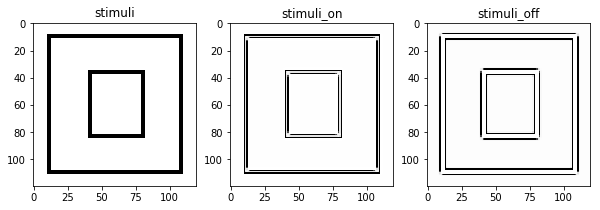

In [14]:
# stimuli_file = './pic_120_dashed.tif'
stimuli_on, stimuli_off = load_stimuli(stimuli_file)
# stimuli_on, stimuli_off = random_stimuli(r_length)

gc.collect()

In [15]:
previous_spike_count = np.zeros(n_L4)

input_groups['LGN_on'].rates = 0 * Hz
input_groups['LGN_off'].rates = 0 * Hz

net.run(0*second)

j = 0

while j < (num_epochs):
    spike_rates_on = stimuli_on.reshape((n_LGN)) / 8. *  input_intensity
    spike_rates_off = stimuli_off.reshape((n_LGN)) / 8. *  input_intensity
    
    input_groups['LGN_on'].rates = spike_rates_on * Hz
    input_groups['LGN_off'].rates = spike_rates_off * Hz

    print('run example number:', j, 'of', num_epochs)

    net.run(single_example_time, report='text')   # 0.35 s

    current_spike_count = np.asarray(spike_counter.count[:]) - previous_spike_count
    previous_spike_count = np.copy(spike_counter.count[:])

    if np.sum(current_spike_count) < 1:
        if (input_intensity == 10):
            break;

        print("F - spike count", np.sum(current_spike_count))
        input_intensity += 1

        input_groups['LGN_on'].rates = 0 * Hz
        input_groups['LGN_off'].rates = 0 * Hz
        net.run(resting_time) 

    else:     
        print("S - spike count", np.sum(current_spike_count))

        if j % 100 == 0 and j > 0:
            print('runs done:', j, 'of', num_epochs)

        input_groups['LGN_on'].rates = 0 * Hz
        input_groups['LGN_off'].rates = 0 * Hz

        net.run(resting_time)
        input_intensity = start_input_intensity
        j += 1
    
    # garbage collect after each iteration
    gc.collect()

run example number: 0 of 10
Starting simulation at t=0. s for a duration of 0.35 s
0.35 (100%) simulated in 9s
S - spike count 16.0
run example number: 1 of 10
Starting simulation at t=0.5 s for a duration of 0.35 s
0.09837058823529411 (28%) simulated in 10s, estimated 26s remaining.
0.35 (100%) simulated in 13s
S - spike count 110
run example number: 2 of 10
Starting simulation at t=1. s for a duration of 0.35 s
0.08664444444444445 (24%) simulated in 10s, estimated 30s remaining.
0.35 (100%) simulated in 10s
S - spike count 118
run example number: 3 of 10
Starting simulation at t=1.5 s for a duration of 0.35 s
0.06358648648648649 (18%) simulated in 10s, estimated 45s remaining.
0.35 (100%) simulated in 10s
S - spike count 123
run example number: 4 of 10
Starting simulation at t=2. s for a duration of 0.35 s
0.04953617021276598 (14%) simulated in 10s, estimated 1m 1s remaining.
0.35 (100%) simulated in 10s
S - spike count 111
run example number: 5 of 10
Starting simulation at t=2.5 s f

In [16]:
# save_connections()

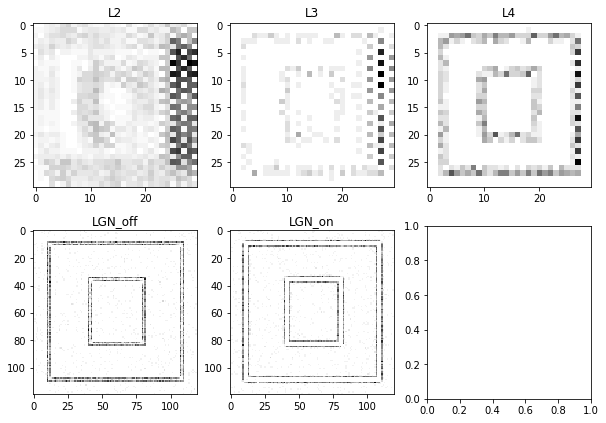

In [17]:
c_shape = (c_length,c_length)
r_shape = (r_length,r_length)
c, axarr = subplots(2,3, figsize = (10, 7))

axarr[0,0].imshow(get_plot_counts('L2', 'spike', c_shape), cmap = cmap.get_cmap('binary'))
axarr[0,0].title.set_text('L2')

axarr[0,1].imshow(get_plot_counts('L3', 'spike', c_shape), cmap = cmap.get_cmap('binary'))
axarr[0,1].title.set_text('L3')

axarr[0,2].imshow(get_plot_counts('L4', 'spike', c_shape), cmap = cmap.get_cmap('binary'))
axarr[0,2].title.set_text('L4')

axarr[1,0].imshow(get_plot_counts('LGN_on', 'spike', r_shape), cmap = cmap.get_cmap('binary'))
axarr[1,0].title.set_text('LGN_off')

axarr[1,1].imshow(get_plot_counts('LGN_off', 'spike', r_shape), cmap = cmap.get_cmap('binary'))
axarr[1,1].title.set_text('LGN_on')

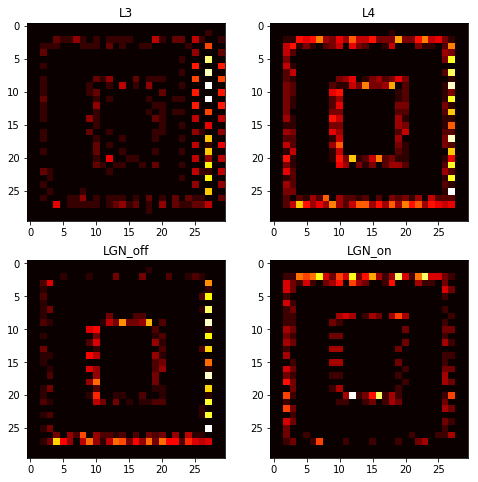

In [18]:
c, axarr = subplots(2,2, figsize = (8, 8))

axarr[0,0].imshow(get_plot_counts('L3', 'theta', c_shape), cmap = cmap.get_cmap('hot'))
axarr[0,0].title.set_text('L3')

axarr[0,1].imshow(get_plot_counts('L4', 'theta', c_shape), cmap = cmap.get_cmap('hot'))
axarr[0,1].title.set_text('L4')

axarr[1,0].imshow(get_plot_counts('L4_NF', 'theta', c_shape), cmap = cmap.get_cmap('hot'))
axarr[1,0].title.set_text('LGN_off')

axarr[1,1].imshow(get_plot_counts('L4_FN', 'theta', c_shape), cmap = cmap.get_cmap('hot'))
axarr[1,1].title.set_text('LGN_on')

In [19]:
save_connections()

NameError: name 'save_connections' is not defined

In [ ]:
# plot(state_monitors['L4_v'].t/ms, state_monitors['L4_v'].v[0], label='L4_v')
# plot(state_monitors['L4_i_v'].t/ms, state_monitors['L4_i_v'].v[0], label='L4_i_v')
# xlabel('Time (ms)')
# ylabel('v')
# legend();

In [ ]:
# plot_graph('L4', 'spike', c_shape)
# fig_num += 1

In [ ]:
# plot_graph('L4_NF', 'theta', c_shape)
# fig_num += 1

In [ ]:
# (conn.i, conn.j, conn.w)